In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [ ]:
features = 'PANNs'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/AcousticIndices_data/ReyZamuro/RZUA01_AIs.csv'
n_feat=60
10
                                                                  file
Date                                                                  
2022-09-05 10:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
11
                                                                  file
Date                                                                  
2022-09-05 11:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
12
           

In [6]:
x.shape

torch.Size([3, 92, 24, 60])

## Edge Creation

In [7]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [8]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [9]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Crear modelo y entrenar

In [ ]:
from models import MatrixGCN, MatrixGAT


# Initialize model and optimizer
model = MatrixGAT(in_channels=64*2048, hidden_channels=2048, embedding_dim=8)#num_filters conv1d x num_original_features
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.01 GCN


# Unsupervised loss function (e.g., graph regularization)
def unsupervised_loss(embedding, edge_index):
    # This loss encourages connected nodes to have similar embeddings
    src, dst = edge_index
    distance = F.pairwise_distance(embedding[src], embedding[dst])
    return distance.mean()

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        embedding = model(graph.x.double(), graph.edge_index)
        loss = unsupervised_loss(embedding, graph.edge_index)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 12): #Oversmoothing?
    loss = train()
    if epoch % 3 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 003, Loss: 1512.2708
Epoch: 006, Loss: 587.7485
Epoch: 009, Loss: 291.1983


In [32]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        embeddings = model(graph.x.double(), graph.edge_index)

In [33]:
graph

DataBatch(x=[92, 24, 60], edge_index=[2, 1260], batch=[92], ptr=[2])

In [34]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 8])


In [35]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [36]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)
sim_mat

array([[4.17744947, 4.17744947, 0.76615346, ..., 3.5137952 , 2.16547288,
        3.62334509],
       [4.17744947, 4.17744947, 0.76615346, ..., 3.5137952 , 2.16547288,
        3.62334509],
       [0.76615346, 0.76615346, 3.        , ..., 0.66277108, 1.24986281,
        1.116244  ],
       ...,
       [3.5137952 , 3.5137952 , 0.66277108, ..., 3.29283169, 2.02242592,
        3.07179097],
       [2.16547288, 2.16547288, 1.24986281, ..., 2.02242592, 2.58957443,
        2.57600996],
       [3.62334509, 3.62334509, 1.116244  , ..., 3.07179097, 2.57600996,
        3.57909438]])

In [37]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [39]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

In [40]:
np.triu(sim_mat, k=-1)

array([[4.17744947, 4.17744947, 0.76615346, ..., 3.5137952 , 2.16547288,
        3.62334509],
       [4.17744947, 4.17744947, 0.76615346, ..., 3.5137952 , 2.16547288,
        3.62334509],
       [0.        , 0.76615346, 3.        , ..., 0.66277108, 1.24986281,
        1.116244  ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.29283169, 2.02242592,
        3.07179097],
       [0.        , 0.        , 0.        , ..., 2.02242592, 2.58957443,
        2.57600996],
       [0.        , 0.        , 0.        , ..., 0.        , 2.57600996,
        3.57909438]])

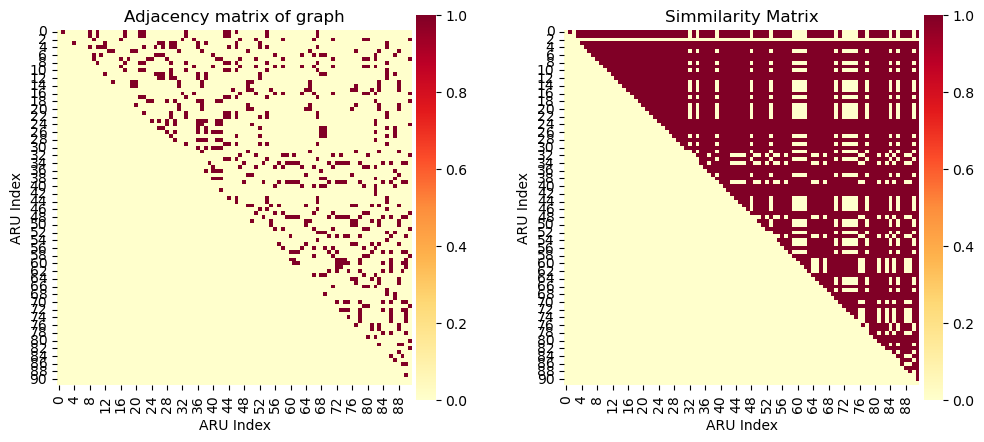

In [41]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=1), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=1)>2.5, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

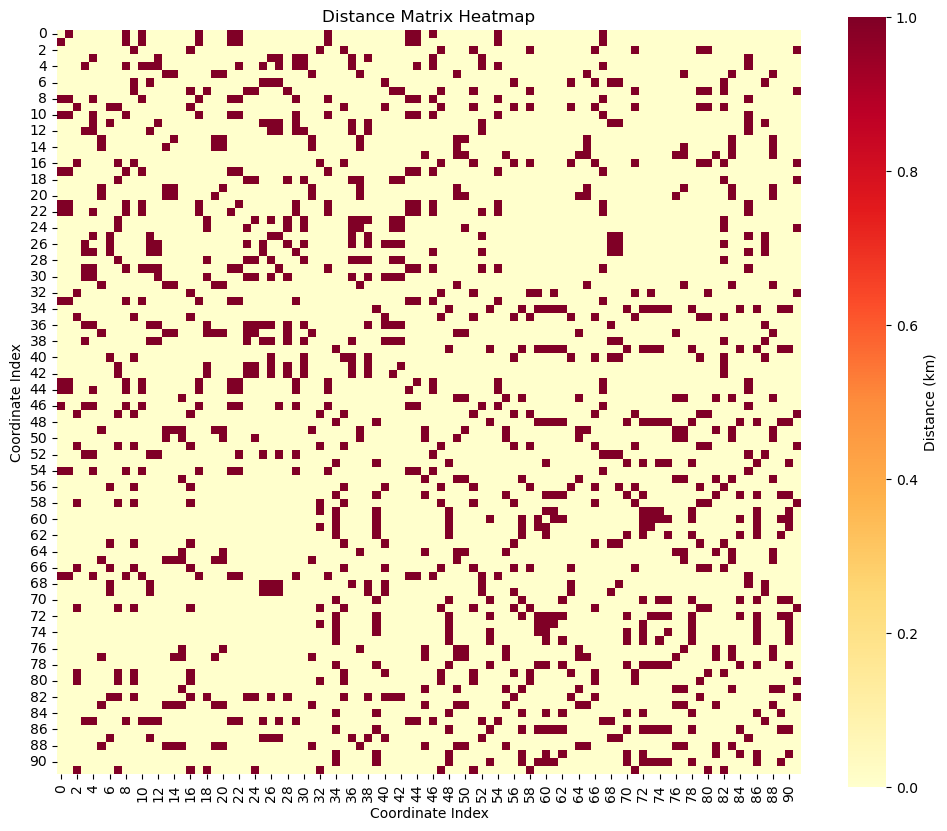

In [42]:
plot_distance_matrix_heatmap(adj_graph)

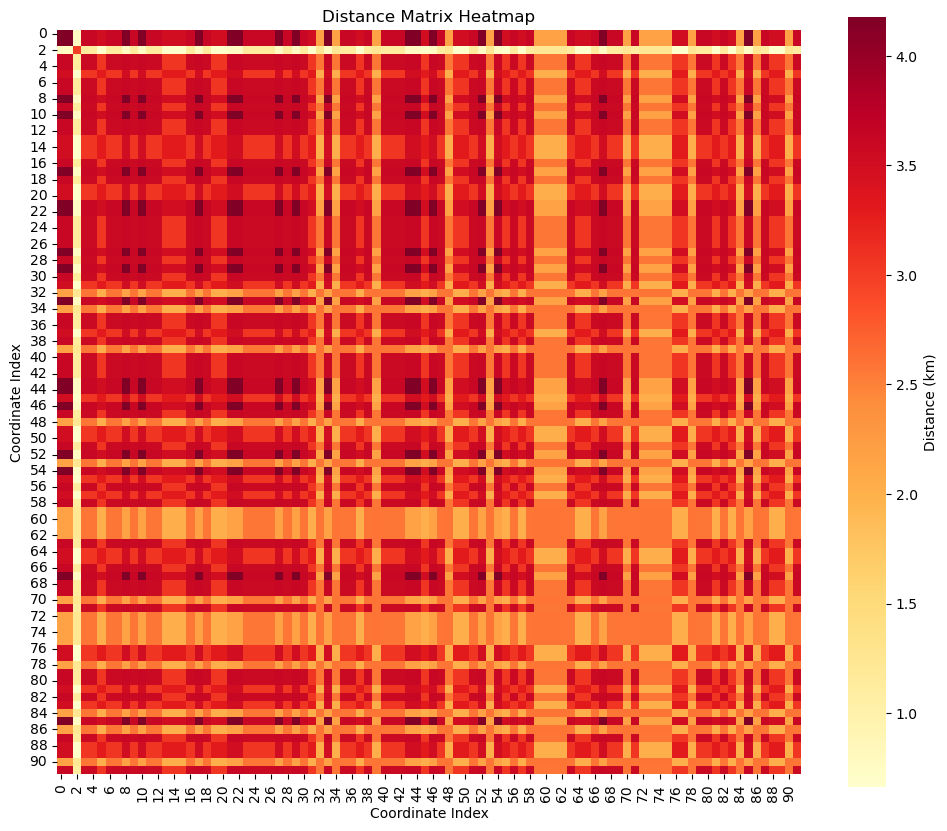

In [43]:
plot_distance_matrix_heatmap(sim_mat)

In [44]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

3.0126431062079866


In [45]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [46]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

25499.011250944397


In [47]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

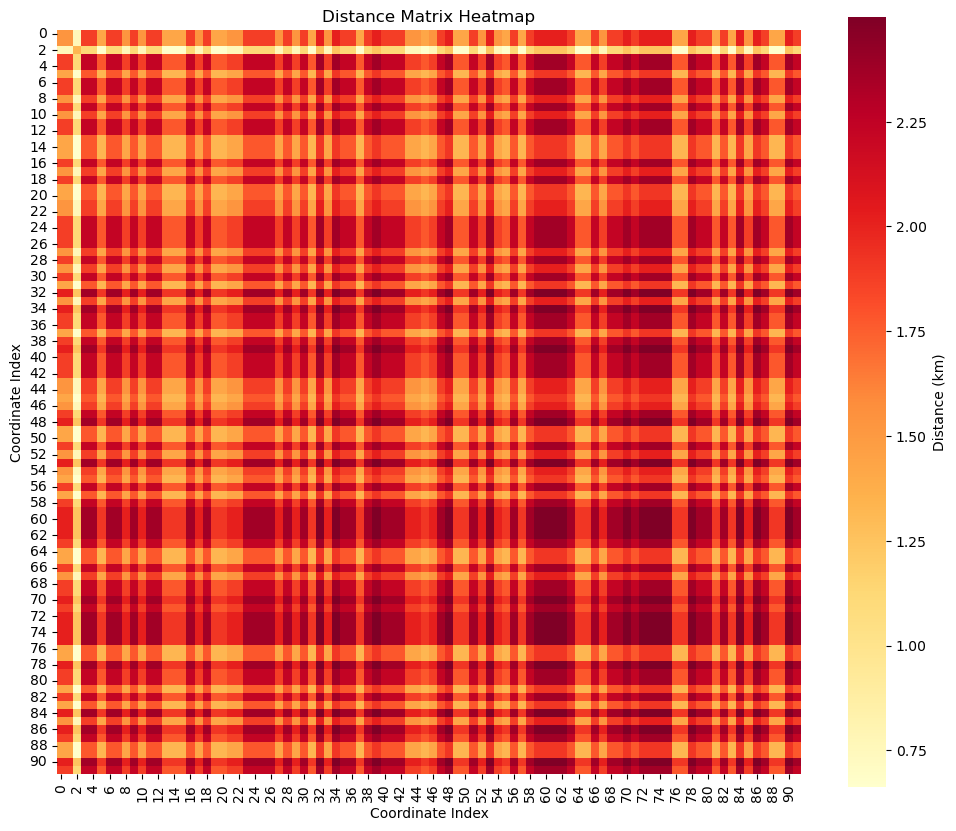

In [48]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [49]:
# diameter
print(np.max(dist_matrix))

2.4997256148492246


In [50]:
#average path
print(np.mean(dist_matrix))

1.9242625214236875


In [51]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

89.02173913043478
